# up and running with prefect
Many types of computations can be broken down into subtasks, some of which may be resource-intensive or long-running, and which may fail at any time for multiple reasons. Being able to define tasks, chain them together, and monitor execution is a nontrivial part of any modern computational pipeline. However, most researchers, data scientists, and software engineers want to focus on solving big-picture questions without worrying about these kinds of bookkeeping details. In the past decade or so, several task management libraries have attempted to make task tracking easy for the programmer, with [Apache Airflow](https://airflow.apache.org/) and [Luigi](https://github.com/spotify/luigi) being some of the most well known.

`prefect` is an open source workflow management library designed to make it simple for users to keep track of task execution with only minimal changes to their code. The first public release of prefect, v0.2.0, was in July of 2018, with the Prefect team releasing on a regular cadence ever since. [prefect.io](Prefect), the company behind the `prefect` library (also known as [Prefect Core](https://www.prefect.io/core) in the official documentation), offers a cloud-based task management dashboard called [Prefect Cloud](https://www.prefect.io/cloud/) as their flagship product. By itself, the `prefect` library is [open source](https://github.com/PrefectHQ/prefect) and totally free to use. Today we'll explore some of `prefect`'s data structures by building a simple pipeline from the ground up. Along the way, we'll show how to

* define the _tasks_ (read: functions) that will make up the pipeline
* chain tasks together into a _flow_ as a way of defining their interdependencies
* run the pipeline, and examine the output
* visualize the task graph with `graphviz`


## installation

First we'll need to install `prefect`; we'll also need [pandas](https://pandas.pydata.org/) and [numpy](https://numpy.org/). For fake data, we'll use [scikit-learn](https://scikit-learn.org/stable/):

```bash
pip install prefect prefect[viz] pandas numpy scikit-learn
```

`prefect[viz]` is an optional extra which is only needed if you want to generate flow visualizations with `graphviz`.


## shipment cost calculations

Let's imagine that we have a list of shipments; these parcels need to be classified according to whether they are shippable as-is, or oversize (and therefore subject to a higher fee). Finally, we need to calculate the total cost of shipping the entire inventory. First, we'll import the required libraries and generate some example data.

In [1]:
    import prefect, pandas, numpy, sklearn.datasets

In [2]:
    sizes, _ = sklearn.datasets.make_blobs(n_features=3, center_box=[10, 100])
    shipments = pandas.DataFrame(sizes, columns=['length [cm]', 'width [cm]', 'height [cm]'])
    shipments

,length [cm],width [cm],height [cm]
0,48.471456,56.583776,26.901890
1,50.406674,58.182694,25.390132
2,30.465590,96.533403,54.410087
3,72.890176,99.476241,29.148703
4,47.224565,57.435845,26.971783
...,...,...,...
95,29.897802,95.952418,52.339577
96,30.802258,94.798504,54.200485
97,30.275031,95.339318,52.369535
98,31.061791,95.806423,52.718098


With `prefect`, the smallest components of a pipeline are called _tasks_. These are individual operations which are usually strung together to carry out loading of data, transformations, and output. `prefect`'s functional API makes it simple to turn Python functions into `prefect` _tasks_ using decorators:

In [3]:
    @prefect.task
    def compute_volume(df: pandas.DataFrame):
        """Compute the volume of each shipment."""
        df = df.copy()
        df['volume [cm^3]'] = df['length [cm]']*df['width [cm]']*df['height [cm]']
        return df

    @prefect.task
    def split_oversize(df: pandas.DataFrame, oversize_volume: float = 125000) -> tuple[pandas.DataFrame, pandas.DataFrame]:
        """Split the dataset into a pair of datasets - one for shippable boxes, the other for oversize boxes."""
        oversize = df['volume [cm^3]'] < oversize_volume
        return df.loc[~oversize], df.loc[oversize]
    
    @prefect.task
    def compute_costs(df: pandas.DataFrame, is_oversize: bool) -> pandas.DataFrame:
        df = df.copy()
        if is_oversize:
            price_per_cc = 0.22
        else:
            price_per_cc = 0.14
        
        df['cost'] = df['volume [cm^3]']*price_per_cc
        return df
    
    @prefect.task
    def compute_total_cost(shippable: pandas.DataFrame, oversize: pandas.DataFrame) -> float:
        return shippable['cost'].sum() + oversize['cost'].sum()

Here, we've defined Python functions as we usually would for computing the volume of each parcel and for splitting the parcels into two dataframes: one group which is oversize, and one group which is not. The only additional code needed to enable monitoring of these tasks is the `@prefect.task` decorator above each function; this decorator turns each function into a `prefect.Task` class instance. In a moment we'll assemble these tasks into a complete pipeline, but if you still want to execute one of these functions independently of the others, you'll need to call the `.run()` attribute:

In [4]:
compute_volume.run(shipments)

,length [cm],width [cm],height [cm],volume [cm^3]
0,48.471456,56.583776,26.901890,73783.760245
1,50.406674,58.182694,25.390132,74464.080377
2,30.465590,96.533403,54.410087,160017.187482
3,72.890176,99.476241,29.148703,211352.601303
4,47.224565,57.435845,26.971783,73157.799846
...,...,...,...,...
95,29.897802,95.952418,52.339577,150150.019445
96,30.802258,94.798504,54.200485,158265.846851
97,30.275031,95.339318,52.369535,151159.465357
98,31.061791,95.806423,52.718098,156884.791515


In order to execute these tasks on our data we'll need to define the order in which they need to be run; we'll do this by chaining them together into a _flow_, which defines their order of execution. 

1. we first need to compute the volume in order to determine whether a parcel is oversize
2. compute the cost of each shipment, with an additional fee added if it is an oversize parcel
3. add the cost of all the shipments together to get the cost of shipping the entire inventory

`prefect` allows us to easily define these dependencies with Python's [context manager syntax](https://docs.python.org/3/library/contextlib.html):

In [5]:
    with prefect.Flow('Shipment Flow') as flow:
        shipments_with_volume = compute_volume(shipments)
        standard, oversize = split_oversize(shipments_with_volume)
        standard_cost, oversize_cost = compute_costs(standard, is_oversize=False), compute_costs(oversize, is_oversize=True)
        total_cost = compute_total_cost(standard_cost, oversize_cost)

One of the most useful features of `prefect` is that it makes it easy to visualize the relationships between the various tasks using `graphviz`:

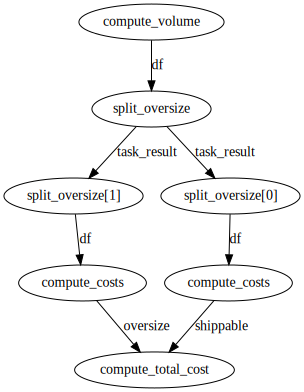

In [6]:
    flow.visualize()

Here, each node of the graph represents a _task_, and each arrow indicates a dependency. Visualizations such as these allow us to quickly confirm that our mental model of the computation matches up with what we intended to program. Brilliant! Okay, the flow has been set up and we're sure the task graph looks good. Let's run it!

In [7]:
    state = flow.run()

[2021-08-10 16:29:09-0700] INFO - prefect.FlowRunner | Beginning Flow run for 'Shipment Flow'
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'compute_volume': Starting task run...
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'compute_volume': Finished task run for task with final state: 'Success'
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'split_oversize': Starting task run...
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'split_oversize': Finished task run for task with final state: 'Success'
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'split_oversize[1]': Starting task run...
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'split_oversize[1]': Finished task run for task with final state: 'Success'
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'split_oversize[0]': Starting task run...
[2021-08-10 16:29:10-0700] INFO - prefect.TaskRunner | Task 'split_oversize[0]': Finished task run for

From the task status information that `prefect` by default logs to stdout, it looks like all tasks executed successfully. Next, let's look at the results.

In [15]:
    state.result

{<Task: split_oversize[0]>: <Success: "Task run succeeded.">,
 <Task: compute_total_cost>: <Success: "Task run succeeded.">,
 <Task: compute_volume>: <Success: "Task run succeeded.">,
 <Task: split_oversize[1]>: <Success: "Task run succeeded.">,
 <Task: compute_costs>: <Success: "Task run succeeded.">,
 <Task: split_oversize>: <Success: "Task run succeeded.">,
 <Task: compute_costs>: <Success: "Task run succeeded.">}

In [16]:
    state.result[total_cost].result

3590932.9723046217

Once more we can visualize the final state of the flow, this time after the run:

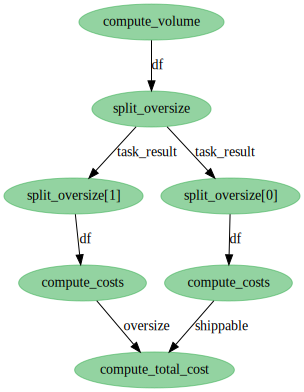

In [8]:
    flow.visualize(flow_state=state)

Each node is now green, indicating that it executed successfully.

* what other problems could this solve?
Although this example is simple, it could be extended to meet the needs of a full-fledged ML pipeline.